In [1]:
import cv2
from datetime import datetime
from glob import glob
from IPython.display import Video, HTML
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
HTML("""
<div align="middle">
<video width="80%" controls>
    <source src="data/ferment_20210301_233006.mp4" type="video/mp4">
</video></div>""")

# Note the bubbling going on in the right tub.  I want to process this video and get a Bubbles-Per-Minute measurement

In [3]:
# Let skip the first 25 frames while the camera auto adjusts it's white balance
cap = cv2.VideoCapture('data/ferment_20210301_233006.mp4')
for i in range(25):
    ret, img = cap.read()

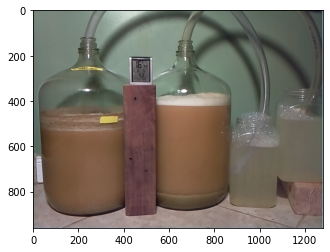

In [4]:
%matplotlib inline
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

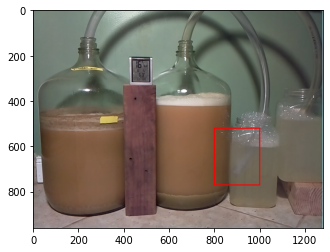

In [5]:
# to make it easy on the detection code 
left_top = (800, 520)
right_bot = (1000, 770)
color = (0, 0, 255)  # BGR
thickness = 3

ret, img = cap.read()
red_box = cv2.rectangle(img, left_top, right_bot, color, thickness)

%matplotlib inline
plt.imshow(cv2.cvtColor(red_box, cv2.COLOR_BGR2RGB))
plt.show()

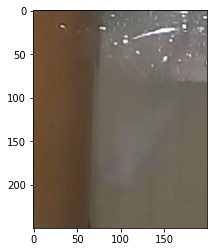

In [6]:
ret, img = cap.read()
crop_img = img[left_top[1]:right_bot[1], left_top[0]:right_bot[0], :].copy()

%matplotlib inline
plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))

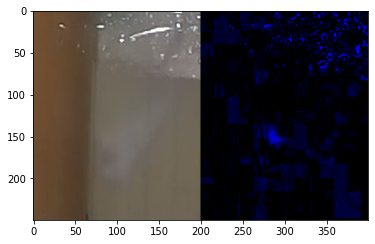

In [7]:
cap = cv2.VideoCapture('data/ferment_20210301_233006.mp4')
for i in range(35):
    ret, img = cap.read()

ret, img1 = cap.read()    
ret, img2 = cap.read()
# lets subtract the two images and multiple the difference 
# I then multiply by 20 just to make it pop more
crop_img1 = img1[left_top[1]:right_bot[1], left_top[0]:right_bot[0], :].copy()
crop_img2 = img2[left_top[1]:right_bot[1], left_top[0]:right_bot[0], :].copy()
diff_img = cv2.multiply(cv2.subtract(crop_img2, crop_img1), 20)

# this new image is joined to the original image so they can be shown side by site
joined_img = np.concatenate([crop_img2, diff_img], axis=1)
%matplotlib inline
plt.imshow(cv2.cvtColor(joined_img, cv2.COLOR_BGR2RGB))

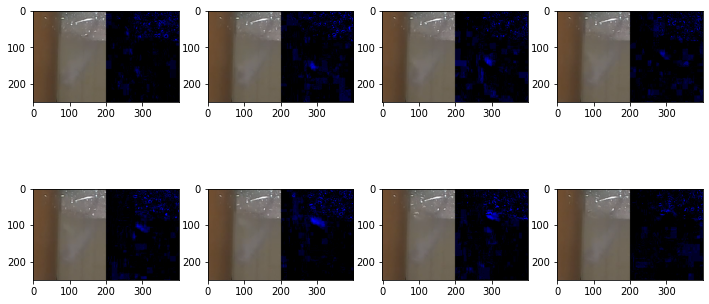

In [8]:
%matplotlib inline

cap = cv2.VideoCapture('data/ferment_20210301_233006.mp4')
for i in range(34):
    cap.read()  # just read off the first 25 images again
    
plt.figure(figsize=(12,6))
ret, img = cap.read()
prev_img = img[left_top[1]:right_bot[1], left_top[0]:right_bot[0], :].copy()
for i in range(1,9):
    ret, img = cap.read()
    new_img = img[left_top[1]:right_bot[1], left_top[0]:right_bot[0], :].copy()
    sub = cv2.multiply(cv2.subtract(new_img, prev_img), 20)
    joined_img = np.concatenate([new_img, sub], axis=1)
    prev_img = new_img
    plt.subplot(2,4,i)
    plt.imshow(cv2.cvtColor(joined_img, cv2.COLOR_BGR2RGB))

## So the bubble can be seen in ~6 frames there.  Lets now take the original 30 second video and make a video of our clipped area:
- I did make the box a little bbigger for context
- also I am now, converting my diff_img to gray scale

In [9]:
# making our clipped box a little bit bigger for context
right_bot = (1000, 750)
left_top = (830, 550)

cap = cv2.VideoCapture('data/ferment_20210301_233006.mp4')
ret, img = cap.read()
prev_img = img[left_top[1]:right_bot[1], left_top[0]:right_bot[0], :].copy()

if os.path.exists('video1.mp4'):
    os.remove('video1.mp4')
frame_size = (np.shape(prev_img)[1]*2, np.shape(prev_img)[0])
frame_rate = 5
video = cv2.VideoWriter('video1.mp4', cv2.VideoWriter_fourcc(*"MJPG"), frame_rate, frame_size, isColor=True)
for i in range(1,620):
    ret, img = cap.read()
    new_img = img[left_top[1]:right_bot[1], left_top[0]:right_bot[0], :].copy()
    #diff_img = cv2.multiply(cv2.subtract(new_img, prev_img), 20)        
    diff_img = cv2.cvtColor(cv2.multiply(cv2.cvtColor(cv2.subtract(new_img, prev_img),  cv2.COLOR_BGR2GRAY), 20), cv2.COLOR_GRAY2RGB)      
    joined_img = np.concatenate([new_img, diff_img], axis=1)
    prev_img = new_img
    video.write(joined_img)

video.release()
from IPython.display import Video
Video('video1.mp4', width=frame_size[0]*2, height=frame_size[1]*2)

In [10]:
# making our clipped box a little bit bigger for context
right_bot = (1000, 750)
left_top = (830, 550)

cap = cv2.VideoCapture('data/ferment_20210301_233006.mp4')
ret, img = cap.read()
prev_img = img[left_top[1]:right_bot[1], left_top[0]:right_bot[0], :].copy()

if os.path.exists('video2.mp4'):
    os.remove('video2.mp4')
frame_size = (np.shape(prev_img)[1]*2, np.shape(prev_img)[0])
frame_rate = 5
video = cv2.VideoWriter('video2.mp4', cv2.VideoWriter_fourcc(*"MJPG"), frame_rate, frame_size, isColor=True)
for i in range(1,620):
    ret, img = cap.read()
    new_img = img[left_top[1]:right_bot[1], left_top[0]:right_bot[0], :].copy()
    #diff_img = cv2.multiply(cv2.subtract(new_img, prev_img), 20)        
    diff_img = cv2.cvtColor(cv2.subtract(new_img, prev_img),  cv2.COLOR_BGR2GRAY)
    
    ind = np.nonzero(diff_img>5)
    diff_img[:] = 0
    diff_img[ind] = 255
    diff_img_rgb = cv2.cvtColor(diff_img, cv2.COLOR_GRAY2RGB)
    
    joined_img = np.concatenate([new_img, diff_img_rgb], axis=1)
    prev_img = new_img
    video.write(joined_img)

video.release()
from IPython.display import Video
Video('video2.mp4', width=frame_size[0]*2, height=frame_size[1]*2)

## Next lets try our hand at object detection.  This is not the right way to do this. but I'm using cv2.findContours to find a block.  If the contour I find has more than 20 points its probably a big area and I circle it in green. Otherwise if its between 10 and 20 I circle it red

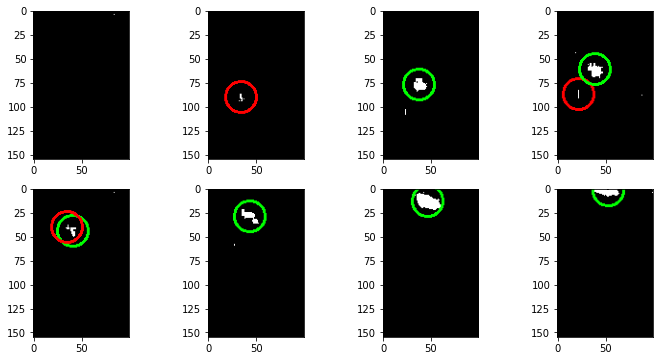

In [11]:
# Lets tighten up the box we are looking at a little bit
# right_bot = (1000, 750)
# left_top = (830, 550)
left_top = (850, 595)
right_bot = (950, 750)

cap = cv2.VideoCapture('data/ferment_20210301_233006.mp4')
for i in range(33):
    cap.read()  # just read off the first 25 images again

plt.figure(figsize=(12,6))
ret, img = cap.read()
prev_img = img[left_top[1]:right_bot[1], left_top[0]:right_bot[0], :]
for i in range(1,9):
    ret, img = cap.read()
    new_img = img[left_top[1]:right_bot[1], left_top[0]:right_bot[0], :]
    
    # create a gray-scale difference image
    diff_img = cv2.cvtColor(cv2.subtract(new_img, prev_img), cv2.COLOR_BGR2GRAY)
    
    # Lets find all pixels with greater than a 5 difference and max them out
    ind = np.nonzero(diff_img>5)
    diff_img[:] = 0
    diff_img[ind] = 255
    
    # find contours on our differnece image
    contours, hierarchy = cv2.findContours(diff_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    
    # conver the image back to color for drawing our circles on it
    contour_img = cv2.cvtColor(diff_img, cv2.COLOR_GRAY2RGB)
    
    for contour in contours:
        # find contours with more than 20 points and paint green
        if len(contour) > 10 and len(contour) < 20:
            center = np.array(np.mean(np.concatenate(contour), axis=0), 'i')
            cv2.circle(contour_img, center, radius=16, color=(0,0,255), thickness=2)
            
        elif len(contour) > 20:
            center = np.array(np.mean(np.concatenate(contour), axis=0), 'i')
            cv2.circle(contour_img, center, radius=16, color=(0,255,0), thickness=2)
            
    plt.subplot(2,4,i)
    plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
    prev_img = new_img

In [12]:
def detect_bubbles_from_vid(fn):
    left_top = (850, 603)
    right_bot = (950, 750)

    cap = cv2.VideoCapture(fn)
    for i in range(25):
        cap.read()  # just read off the first 25 images again

    ret, img = cap.read()
    prev_img = img[left_top[1]:right_bot[1], left_top[0]:right_bot[0], :]
    found = []
    i = 0
    while 1:
        ret, img = cap.read()
        if not ret:
            break
        new_img = img[left_top[1]:right_bot[1], left_top[0]:right_bot[0], :]
    
        # create a gray-scale difference image
        diff_img = cv2.cvtColor(cv2.subtract(new_img, prev_img), cv2.COLOR_BGR2GRAY)
    
        # Lets find all pixels with greater than a 5 difference and max them out
        ind = np.nonzero(diff_img>5)
        diff_img[:] = 0
        diff_img[ind] = 255
    
        # find contours on our differnece image
        contours, hierarchy = cv2.findContours(diff_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    
        # conver the image back to color for drawing our circles on it
        contour_img = cv2.cvtColor(diff_img, cv2.COLOR_GRAY2RGB)
    
        for contour in contours:            
            if len(contour) > 15:
                center = np.array(np.mean(np.concatenate(contour), axis=0), 'i')
                found.append([i, center])
        i += 1 
        
    bubble_start = -999
    last_bubble_seen = -999

    # this will get filled with:
    #     bubble_start, num_times, bubble_end
    # it will allow 2 seconds to be missed between bubbles being seen
    bubble_locs = []
    bubble_cnt = 0
    bubbles = []
    for frame, loc in found:
        if bubble_start == -999:
            bubble_start = frame
            bubble_locs.append(loc)
            bubble_last_seen = frame
        elif frame - bubble_last_seen > 3:
            if len(bubble_locs) > 3:
                bubbles.append([bubble_start, bubble_locs])
            bubble_start = frame
            bubble_last_seen = frame
            bubble_locs = [loc]
        else:
            bubble_last_seen = frame
            bubble_locs.append(loc)

    if len(bubbles) > 0:
        frames, bubble_locs = np.transpose(bubbles)
        return frames, bubble_locs
    else:
        return [], []

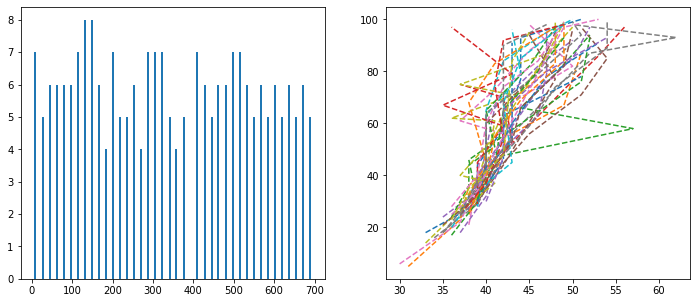

In [13]:
%matplotlib inline
frames, bubble_locs = detect_bubbles_from_vid('data/ferment_20210301_233006.mp4')
plt.figure(figsize=(12,5))
num_detections_per_frame = []
for x in bubble_locs:
    num_detections_per_frame.append(len(x))
plt.subplot(121)
plt.bar(frames, height=num_detections_per_frame, width=5)
plt.subplot(122)
for loc in bubble_locs:
    x, y = np.transpose(loc)
    plt.plot(x,100-y,'--')
plt.show()